<a href="https://colab.research.google.com/github/BreakoutMentors/Data-Science-and-Machine-Learning/blob/main/machine_learning/lesson%202%20-%20logistic%20regression/Classification_Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> Note: Always open in Colab for the best learning experience.

# Classification: Logistic Regression
In the previous lessons, we learned about linear regression and how we can use it to construct a single layer linear neural network to predict a numeric value (i.e., how powerful a Pokemon is given their x features). Regression is great when we want to answer *how much?* or *how many?* questions. In practice, we are often more interested in *classification*: asking *which one?* not *how much?*
- Is this customer more likely to *sign up* or *not* for a subscription service?
- Does this image contain one of the following, a cat or a dog?
- Is this song in the genre of hip hop, pop, or funk?

When we want to distinguish two classes (called *binary classification*), we can use a classification technique called logistic regression.

In this notebook, we will learn the foundations of logistic regression and demonstrate how to solve binary classification problems using an example--building a logistic regression model to predict whether it will rain the next-day or not. The ideas we introduce here will build on previous material and continue to lay out the fundamental concepts used in deep learning and neural networks, which we will cover in future lessons. Here is the lesson roadmap:
1. Introduction to logistic regression
2. From linear to logistic regression
3. Building a logistic regression classifier: predicting if it rains tomorrow
7. Summary



# Representing categorical data
<figure>
  <img src='https://envato-shoebox-0.imgix.net/2718/a008-795b-4376-972d-ed9cbad8ac4f/2015_227_003_0063_A_2018_07_19.jpg?auto=compress%2Cformat&fit=max&mark=https%3A%2F%2Felements-assets.envato.com%2Fstatic%2Fwatermark2.png&markalign=center%2Cmiddle&markalpha=18&w=700&s=e3fbeb220008b297bee64675504ae70c' width='50%'>
  <figcaption>Representing data: a Shina Inu, Retriever, and Lab</figcaption>
</figure>



Before we dive into logistic regression, let's consider how machine learning problems generally represents categorical data. 

Categorical features represent types of data which may be divided into groups. Examples of categorical features are dog breed, game genre, and educational level. While the latter feature may also be considered in a numerical manner by using exact values for  highest grade completed, it is often more informative to categorize such variables into a relatively small number of groups.

Consider an example where we want to distinguish 3 different dog breeds--(golden) retrievers, labs, and shiba inus, given 3 features about each dog: height, weight, and fur color. The numeric features are height ($x_1$) and weight ($x_2$), while the categorical feature is fur color ($x_3$), which we determined has 3 colors: black, red, yellow (golden/light gold). To make this categorical feature useful, we need to convert it into a numerical representation. 

There are two general ways to represent categorical data in numeric terms. Perhaps the most natural choice to is to choose $x_3 \in \{1, 2, 3\}$, where the integers represent the fur colors {black, red, yellow} repectively. This is a great way to compress and store info on a computer, but it's not great for machine learning. Fortunately, great minds got together long ago and invented a simple method to represent categorical data called *one-hot encoding*. A one-hot encoding is a vector with as many components as we have categories. The component corresponding to particular sample's category is set to 1 and all other components are set to 0. So in our case, this translates to:

$$
x_3 \in \{ (1, 0, 0), (0, 1, 0), (0, 0, 1) \},
$$

where $x_3$ would be a three-dimensional vector representing the fur color feature with $(1, 0, 0)$ corresponding to "black", (0, 1, 0) to "red", and (0, 0, 1) to "yellow" fur.

## Challenge: Representing categorical data
Now that you know how to represent categorical data, consider the dog breed example above. We one-hot encoded the fur color feature $x_3$ so that all the features $x_1, x_2, x_3$ were represented by numeric values. Thus, the features ($\mathbf{x}$) were ready to be passed as input to a machine learning model. On the other hand, are the labels $y$ (the dog bread) ready? Are they in the proper format? How should $y$ be *encoded*? Write your answer in the text cell below. 

Hint: currently, $y \in \{\ \text{retrievers}, \text{labs}, \text{shiba inus} \}$ is a one-dimensional vector with categorical values.   

# Intro to logistic regression
<figure>
  <img src='https://www.elie.net/static/images/images/challenges-faced-while-training-an-ai-to-combat-abuse/dog-vs-cat.jpg' width='70%'>
  <figcaption>Classification: Cat vs Dog</figcaption>
</figure>

With a healthy understanding of categorical encoding, let's dive into the logistic regression method.

Logistic regression is perhaps the simplest and most common machine learning algorithm for binary classification tasks. It is a special case of linear regression where the labels variable ($y$) is categorical in nature. It is called "logistic" regression because it uses a *logit* function, called the *sigmoid* function, to estimate the probability of a given class.

To motivate logistic regression, let's consider a simple image classification problem--distinguish between cat and dog photos. Here, each image consists of a $2 \times 2$ grayscale image. We can represent each pixel value with a single scalar (number), giving us four features $x_1,x_2,x_3,x_4$. Further, let's assume that each image belongs to one among the categories “cat” and “dog”. However, as we demonstrated in the previous section, we can't use the labels $y$ in its current format ("cat" and "dog"). We need to convert the labels to discrete numerical values (i.e., 0 and 1). To this end, we map each category to an integer, making $y \in \{0,1\}$, where the integers represent $\{\text{cat}, \text{dog}\}$ repsectively. Notice that this is not exactly like *one-hot encoding*, where the one-dimensional vector is converted into a multi-dimensional vector with dimensions equivalent to the number of classes in the labels $y$. Instead, we used the simpler (first) method we discussed in the previous section: encoding each category as a numerical value, in this case $\{0, 1\}$ corresponding to $\{\text{cat}, \text{dog}\}$. When we only need to encode two categories (called binary categorization), we don't have to use one-hot encoding. However, we do need to encode the data numerically. Specifically, among the category labels, we need to assign 0 to one category and 1 to the other.


# From linear to logistic regression
<figure>
  <img src='https://miro.medium.com/max/1400/1*dm6ZaX5fuSmuVvM4Ds-vcg.jpeg' width='70%'>
  <figcaption>Linear vs Logistic Regression | Source: Datacamp</figcaption>
</figure>

Now that we know how labels are properly *encoded*, let's demonstrate the connection between linear and logistic regression.

When we are doing linear regression the equation is as follows:

$$
\hat{\mathbf{y}} = \mathbf{w} \mathbf{X} + b,\tag{1}
$$

where the linear model learns the most *optimal* parameter values for the *weights* ($\mathbf{w}$) and *bias* term ($b$). The linear regression method is great when we want to predict continuous numerical data, but not so good when we need to distinguish between classes. 

To make a binary logistic classifier to distinguish between cat and dog photos, we need to convert the predictions ($\hat{\mathbf{y}}$) into probabilities ($\hat{\mathbf{p}}$). Here, each sample is assigned a corresponding probability $\hat{p}$ that indicates the model's degree of *certainty* that it belongs to a particular class (in our case, cat or dog). Further, we set a threshold, usually 0.5, that the model will use to determine the final class prediction. For our cat ($y=0$) and dog ($y=1$) problem, a sample with a $\hat{p}$ value greater than 0.5 would receive the "dog" label for example. 

In order to predict classes, logistic regression maps predictions ($\hat{\mathbf{y}}$) to probabilities ($\hat{\mathbf{p}}$) via the *sigmoid* logit function:
$$
\tag{2}
p = \sigma(y) = \frac{1}{1 + e^{-y}},
$$

which leads us to the equation for logistic regression: 
$$
\tag{3}
\hat{\mathbf{p}} = \sigma(\hat{\mathbf{y}}) = \frac{1}{1 + e^{-(\hat{\mathbf{w} \mathbf{X} + b})}}, 
$$ 

where the logistic model (binary classifier) learns the most *optimal* parameter values ($\mathbf{w}$ and $b$) by producing probabilities ($\hat{\mathbf{p}}$) that *maximize the likelihood* of predicting the observed data. 

Generally, the logistic regression equation from $(3)$ is compressed:

$$
\tag{4}
\hat{\mathbf{p}} = \sigma(\hat{\mathbf{y}}) = \sigma(\hat{\mathbf{w} \mathbf{X} + b}),
$$

where $\sigma$ represents the sigmoid function (eq. $2$) in this case. Does this equation look similar to linear regression yet?

To summarize logistic regression:
- Category labels are converted to discrete integer values (e.g., 0 and 1).
- The *sigmoid* logit function maps input features ($\mathbf{x}$) to probabilities (i.e., a number between 0 and 1).
- A category prediction is determined by the threshold value (usually 0.5) and the probability (i.e., in our cat/dog example, a sample with a probability greater than 0.5 is classified as a dog image).   
- Logistic regression classifiers try to maximize *certainty*: predict a particular class with high confidence ($\hat{p}$ closer to 1) and be correct (after thresholding, $\hat{p} = y$), most of the time.  

# Logistic Regression: predicting if it rains tomorrow
Now that we know about the fundamentals of logistic regression, let's apply this method to a real-world problem--predicting if it rains the next day in Austrailia based on daily data. In this section, we will demonstrate in an end-to-end fashion the process of creating a logistic regression classifier: from building, to training, and finally evaluating the model. This process involves several steps:

1. Find a dataset related to our question.
2. Explore the dataset and prepare it for the model.
3. Build the model.
4. Train the model using an algorithm such as stochastic gradient descent.
5. Evaluate the quality of our model.
Draw conclusions.

For step 1, we found the [Rain in Australia](https://www.kaggle.com/jsphyg/weather-dataset-rattle-package). The dataset contains approximately 145,000 samples when uncleaned, each representing daily weather data and whether it rained the next day. It provides data like location, temperature, amount of rainfall, windspeed and so much more!

In [1]:
# import the libraries we be need
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# importing PyTorch
import torch
import torch.nn as nn

## 2. Explore the dataset and prepare it for our model
In this section we will focus on defining the   *features* ($\mathbf{x}$) and *labels* ($\mathbf{y}$) that we will use in our logistic regression classifier to predict next-day rain. As you will see, this require us to do some data cleaning and preprocessing.

In [2]:
data_url = 'https://raw.githubusercontent.com/BreakoutMentors/Data-Science-and-Machine-Learning/main/datasets/weatherAUS.csv'
df = pd.read_csv(data_url)
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [3]:
# check the column types and get basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

### Removing Null Values

I will be doing two steps to remove null values
1. Remove columns that have more than $\frac{1}{4}$ of missing data
2. Remove rows that have any mission data

In [4]:
# Printing the columns with more than 1/4 of column has nulls to remove those
nan_cols = df.isna().sum() > (0.25 * df.shape[0])
nan_cols = nan_cols[nan_cols].index.tolist()
print("These are columns that have more than 1/4 of the column missing")
print(nan_cols)

# Removing those columns
df = df.drop(columns=nan_cols)

# For easy cleaning, will be removing all rows with missing data
df = df.dropna()

These are columns that have more than 1/4 of the column missing
['Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm']


In [5]:
print('Number of missing values: ', df.isna().sum().sum())

Number of missing values:  0


### Feature Extraction from Dates

The 'Date' column contains the date of when the data was collected. If we are planning to predict if it will rain tomorrow, then you can believe months can have an effect of when it rains. Therefore, a new column named 'month' is created which will be used for the model.

The 'Date' column is originally an *object* datatype column, but we will use `pd.to_datatime()` to convert the column data type into *datetime64[ns]* data type so pandas can understand the column as actual dates, not strings. Then using the `dt.month` attribute of `df['Date']`, you can get the month of every entry and save the returned pandas Series and save that Series to a new column in the dataframe.

After saving the month, we can remove the 'Date' column since it we cannot input that into our model.

In [6]:
# Changing column Date from object data type to datetime64[ns]
df['Date'] = pd.to_datetime(df['Date'])

# Creating a new column called 'month'
df['month'] = df.Date.dt.month

# look at the head of 'month'
df.loc[:, ['Date', 'month']].head()

df = df.drop(columns=['Date'])

### Translating string binary columns to [0, 1]

Before translating these columns, we should look at the two distributions. Just to prevent confusion, the 'RainToday' column will be used as a feature variable, and 'RainTomorrow' will be used as the dependent variable which we will be predicting.

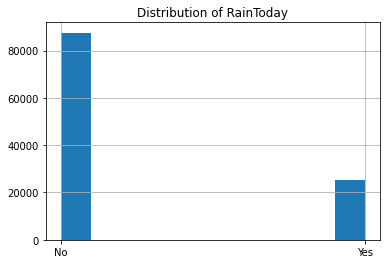

In [7]:
df.RainToday.hist()
plt.title('Distribution of RainToday')
plt.show()

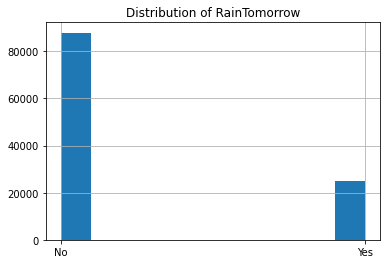

In [8]:
df.RainTomorrow.hist()
plt.title('Distribution of RainTomorrow')
plt.show()

You can see that these two distributions are very similar and that they are very unbalanced. When we separate the data into their training and test sets, we will even the class distribution in column 'Rain Tomorrow'. Now lets convert the 'No' and 'Yes' values to 0's and 1's.

In [9]:
def binary_conversion(rain):
    # returns 1 if it rains
    if rain == 'Yes':
        return 1
    # returns 0 if it did not rain
    else:
        return 0

# Converting those two columns
df['RainToday'] = df['RainToday'].map(binary_conversion)
df['RainTomorrow'] = df['RainTomorrow'].map(binary_conversion)


### One-Hot encoding all categorical data

The way this is done is by one-hot encoding all columns with 'object' data type.

In [10]:
# Getting columns with the object data type
object_cols = df.select_dtypes(include=object).columns.tolist()

# Saving one-hot encoded dataframes to concatenate later
one_hot_dfs = [df.copy()]
for col in object_cols:
    one_hot_df = pd.get_dummies(df[col], prefix=col)
    one_hot_dfs.append(one_hot_df)

# Concatening all dataframes into df again
df = pd.concat(one_hot_dfs, axis=1)

# Dropping the columns used to one-hot encode
df = df.drop(columns=object_cols)

### Balancing the Dataset

The reason why we balance the dataset by variable we try to predict is to prevent overfitting of the class of the highest frequency, for this situation it is 'No' for 'RainTomorrow' column. And in a statistical sense, the model learns the distribution of the training data to make predictions. So if the distribution is highly skewed to one class, it will just predict the class of highest frequency.

In [11]:
def balance_dataset(df):
    df_copy = df.copy()
    df_rain = df_copy.loc[df['RainTomorrow']==1.0, :]
    df_dry = df_copy.loc[df['RainTomorrow']==0.0, :].sample(df_rain.RainTomorrow.value_counts()[1])
    df_copy = pd.concat([df_rain, df_dry]).sample(frac=1, random_state=0)
    return df_copy

df = balance_dataset(df)
df.head()

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,month,Location_Adelaide,Location_Albury,Location_AliceSprings,Location_BadgerysCreek,Location_Ballarat,Location_Bendigo,Location_Brisbane,Location_Cairns,Location_Canberra,Location_Cobar,Location_CoffsHarbour,Location_Dartmoor,Location_Darwin,Location_GoldCoast,Location_Hobart,Location_Katherine,Location_Launceston,Location_Melbourne,Location_MelbourneAirport,Location_Mildura,Location_Moree,Location_MountGambier,Location_Nhil,Location_NorahHead,Location_NorfolkIsland,...,WindGustDir_S,WindGustDir_SE,WindGustDir_SSE,WindGustDir_SSW,WindGustDir_SW,WindGustDir_W,WindGustDir_WNW,WindGustDir_WSW,WindDir9am_E,WindDir9am_ENE,WindDir9am_ESE,WindDir9am_N,WindDir9am_NE,WindDir9am_NNE,WindDir9am_NNW,WindDir9am_NW,WindDir9am_S,WindDir9am_SE,WindDir9am_SSE,WindDir9am_SSW,WindDir9am_SW,WindDir9am_W,WindDir9am_WNW,WindDir9am_WSW,WindDir3pm_E,WindDir3pm_ENE,WindDir3pm_ESE,WindDir3pm_N,WindDir3pm_NE,WindDir3pm_NNE,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW
55133,8.3,17.0,0.2,54.0,26.0,30.0,87.0,48.0,1004.7,1006.5,11.6,16.0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
119029,24.3,32.0,0.0,37.0,13.0,19.0,61.0,61.0,1009.1,1009.1,29.3,28.7,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
121358,7.7,20.3,0.0,19.0,7.0,7.0,72.0,60.0,1019.8,1017.7,12.9,19.9,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
10473,17.0,27.6,0.0,44.0,20.0,30.0,56.0,60.0,1015.5,1013.1,24.8,26.4,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
99958,11.9,32.5,0.0,41.0,9.0,22.0,97.0,39.0,1020.6,1016.2,15.2,29.8,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


### Separating data into Training and Test sets 

In [12]:

# define the x (features) and y (labels) variables
y_col = 'RainTomorrow'
x_cols = df.drop(columns=['RainTomorrow']).columns.tolist()

# split the dataset into train/test datasets 
train = df.sample(frac=0.8, random_state=0)
test = df.drop(train.index)

# Standardizing data sets
train = (train - train.min())/(train.max() - train.min())
test = (test - test.min())/(test.max() - test.min())

# Splitting training data into validation data
valid = train.sample(frac=0.1, random_state=0)
train = train.drop(valid.index) # Deleting rows sampled for validation data

# separate the x (features) and y (labels) in the train/valid/test datasets and normalizing them
train_features = torch.tensor(train[x_cols].values, dtype=torch.float)
test_features = torch.tensor(test[x_cols].values, dtype=torch.float)
valid_features = torch.tensor(valid[x_cols].values, dtype=torch.float)

train_labels = torch.tensor(train[y_col].values.reshape(-1, 1), dtype=torch.float)
test_labels = torch.tensor(test[y_col].values.reshape(-1, 1), dtype=torch.float)
valid_labels = torch.tensor(valid[y_col].values.reshape(-1, 1), dtype=torch.float)

print('train features shape:', train_features.shape)
print('train labels shape:', train_labels.shape)

print('validation features shape:', valid_features.shape)
print('validation labels shape:', valid_labels.shape)

print('test features shape:', test_features.shape)
print('test labels shape:', test_labels.shape)

print('first 5 test labels:\n', test_labels[:5])

train features shape: torch.Size([36027, 106])
train labels shape: torch.Size([36027, 1])
validation features shape: torch.Size([4003, 106])
validation labels shape: torch.Size([4003, 1])
test features shape: torch.Size([10008, 106])
test labels shape: torch.Size([10008, 1])
first 5 test labels:
 tensor([[1.],
        [1.],
        [0.],
        [1.],
        [1.]])


## 3. Build the model
Now that the data is ready, we can build a model. We will use PyTorch to define a simple logistic regression model (single-layer neural network) to predict if it will rain the next day given the weather data of the current day. Given a sample with a corresponding prediction that is above 0.5, the model will assign the "rain" (1) category to it, otherwise it is categorized as "no rain". 

We also define the loss function and optimization algorithm. We will use *binary cross-entropy* loss, *stochastic gradient descent*, and track the *accuracy* metric.

In [13]:
# building logistic model
class Logistic_Model(nn.Module):
    """
    @params
        num_features(int): The number of features to construct the input layer of the NN
    """
    # Defining Constructor
    def __init__(self, num_features):
        super(Logistic_Model, self).__init__()

        # Defining Layers
        self.fc1 = nn.Linear(num_features, 1)

        # Define Sigmoid activation function
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.sigmoid(x)
        return x

# Initializing model
num_features = train_features.shape[1]
model = Logistic_Model(num_features)

# Moving model to use a GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

model

Logistic_Model(
  (fc1): Linear(in_features=106, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [14]:
# Defining Loss Function
criterion = nn.BCELoss()

# Defining optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.2)

## 4. Train the model
No it's time to train the model. We will train it for 100 *epochs* (iterations) with a *batch size* of 1024 (the number of training examples to evaluate prior to doing gradient descent). To use batches, we will load the data into PyTorch [`Datasets`](https://pytorch.org/docs/stable/data.html#dataset-types) and [`Dataloaders`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader). We used [`TensorDataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.TensorDataset) class that creates a PyTorch dataset using the features and labels we already have.

In [15]:
batch_size = 1024

# Defining datasets
train_dataset = torch.utils.data.TensorDataset(train_features, train_labels)
test_dataset = torch.utils.data.TensorDataset(test_features, test_labels)
valid_dataset = torch.utils.data.TensorDataset(valid_features, valid_labels)

# Loading datasets into dataloaders
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [16]:
# Function that takes output and returns predictions
def get_predictions(output, threshold=0.5):
    predictions = torch.zeros(output.shape)
    for i in range(len(output)):
        if output[i] < threshold:
            predictions[i] = 0
        else:
            predictions[i] = 1

    return predictions


epochs = 100
train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []
for epoch in range(1, epochs+1):
    train_loss = 0.0
    valid_loss = 0.0

    train_counts = 0
    valid_counts = 0

    ###################
    # train the model #
    ###################

    # Setting model to train mode
    model.train()

    for train_features, train_labels in train_dataloader:
        # Moving data to GPU if available
        train_features, train_labels = train_features.to(device), train_labels.to(device)
        
        # Setting all gradients to zero
        optimizer.zero_grad()

        # Calculate Output
        output = model(train_features)
            
        # Calculate Loss
        loss = criterion(output, train_labels)

        # Calculate Gradients
        loss.backward()

        # Perform Gradient Descent Step
        optimizer.step()

        # Saving loss
        train_loss += loss.item()

        # Get Predictions
        train_preds = get_predictions(output)

        # Saving number of right predictions for accuracy
        train_counts += train_preds.to(device).eq(train_labels).sum().item()



    ######################    
    # validate the model #
    ######################

    # Setting model to evaluation mode, no parameters will change
    model.eval()
    for valid_features, valid_labels in valid_dataloader:
        # Moving data to GPU if available
        valid_features, valid_labels = valid_features.to(device), valid_labels.to(device)
        # Calculate Output
        output = model(valid_features)

        # Calculate Loss
        loss = criterion(output, valid_labels)

        # Saving loss
        valid_loss += loss.item()

        # Get Predictions
        valid_preds = get_predictions(output)

        # Saving number of right predictions for accuracy
        valid_counts += valid_preds.to(device).eq(valid_labels).sum().item()

    # Averaging and Saving Losses
    train_loss/=len(train_dataset)
    valid_loss/=len(valid_dataset)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    # Getting accuracies and saving them
    train_acc = train_counts/len(train_dataset)
    valid_acc = valid_counts/len(valid_dataset)
    train_accuracies.append(train_acc)
    valid_accuracies.append(valid_acc)


    print('Epoch: {} \tTraining Loss: {:.6f} \tTraining Accuracy: {:.2f}% \tValidation Loss: {:.6f} \tValidation Accuracy: {:.2f}%'.format(epoch, train_loss, train_acc*100, valid_loss, valid_acc*100))

Epoch: 1 	Training Loss: 0.000660 	Training Accuracy: 63.97% 	Validation Loss: 0.000628 	Validation Accuracy: 70.92%
Epoch: 2 	Training Loss: 0.000613 	Training Accuracy: 71.04% 	Validation Loss: 0.000592 	Validation Accuracy: 72.40%
Epoch: 3 	Training Loss: 0.000586 	Training Accuracy: 71.98% 	Validation Loss: 0.000570 	Validation Accuracy: 73.89%
Epoch: 4 	Training Loss: 0.000569 	Training Accuracy: 72.81% 	Validation Loss: 0.000555 	Validation Accuracy: 74.04%
Epoch: 5 	Training Loss: 0.000557 	Training Accuracy: 73.11% 	Validation Loss: 0.000544 	Validation Accuracy: 74.44%
Epoch: 6 	Training Loss: 0.000548 	Training Accuracy: 73.43% 	Validation Loss: 0.000534 	Validation Accuracy: 74.84%
Epoch: 7 	Training Loss: 0.000540 	Training Accuracy: 73.87% 	Validation Loss: 0.000527 	Validation Accuracy: 75.07%
Epoch: 8 	Training Loss: 0.000533 	Training Accuracy: 74.17% 	Validation Loss: 0.000521 	Validation Accuracy: 75.27%
Epoch: 9 	Training Loss: 0.000527 	Training Accuracy: 74.47% 	Va

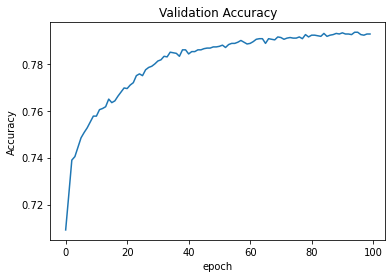

In [17]:
plt.plot(valid_accuracies)
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.show()

As the above plot suggests, our model converges to a validation accuracy close to 78%. 

## 5. Evaluate the model
Now that we trained our model, it's time to evaluate it using the test dataset, which we did not use when training the model. This gives us a sense of how well our model predicts unseen data, which is the case when we use it in the real world.

In [18]:
test_loss = 0.0
test_counts = 0

# Setting model to evaluation mode, no parameters will change
model.eval()

for test_features, test_labels in test_dataloader:
    # Moving data to GPU if available
    test_features, test_labels = test_features.to(device), test_labels.to(device)

    # Calculate Output
    output = model(test_features)

    # Calculate Loss
    loss = criterion(output, test_labels)

    # Saving loss
    test_loss += loss.item()

    # Get Predictions
    test_preds = get_predictions(output)

    # Saving number of right predictions for accuracy
    test_counts += test_preds.to(device).eq(test_labels).sum().item()

# Calculating test accuracy
test_acc = test_counts/len(test_dataset)
print('Test Loss: {:.6f} \tTest Accuracy: {:.2f}%'.format(test_loss, test_acc*100))

Test Loss: 4.569631 	Test Accuracy: 78.55%


Our logistic regression model fitted to the data fairly, correctly predicting the next-day's weather around 77% to 78% of the time. The distribution of rainy days and non-rainy days in our datasets originally was not balanced, but the data was balanced before training. To give our results more context, we should check the *confusion matrix* to see how the model's predictions were distributed.

A confusion matrix indicates the number of correct predictions and incorrect predictions for each class. It is particularly useful whenever the data has an imbalanced representation of the classes. The diagonals of a confusion matrix indicate the correct predictions for each class, while the cross-diagonal indicates misclassified predictions. Below is an example of a binary classification confusion matrix.

<figure>
  <img src='https://rasbt.github.io/mlxtend/user_guide/evaluate/confusion_matrix_files/confusion_matrix_1.png' width='35%'>
  <figcaption>A basic confusion matrix</figcaption>
</figure>

logistic regression model accuracy: 78.55%
confusion matrix:
 [[3992 1011]
 [1136 3869]]


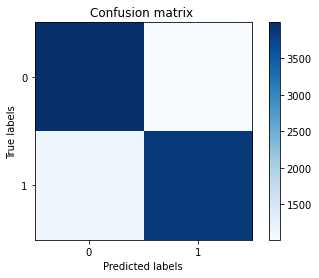

In [19]:
from sklearn import metrics

# Getting test features and labels
test_features = test_dataset.tensors[0].to(device)
test_labels = test_dataset.tensors[1].to(device)

test_predictions = get_predictions(model(test_features)).numpy()

# Converting labels and predictions to numpy arrays
test_predictions = get_predictions(model(test_features)).numpy()
test_labels = test_labels.cpu().numpy()

# measure the accuracy
model_acc = metrics.accuracy_score(test_labels, test_predictions)
print(f'logistic regression model accuracy: {round(model_acc*100, 2)}%')

# plot confusion matrix
cm = metrics.confusion_matrix(test_labels, test_predictions)
print('confusion matrix:\n', cm) 

plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks([0, 1], [0, 1])
plt.yticks([0, 1], [0,1])
plt.title('Confusion matrix ')
plt.colorbar()
plt.show()

From the confusion matrix, we can deduce that the model performed relatively well. The number of misclassified samples of both rainy and non-rainy days were close.  Nonetheless, it's important to be aware of misleading model results, therefore the confusion matrix is very important tool to use.

Let's take a look at a more comprehensive set of evaluation metrics: accuracy, precision, and recall. Precision indicates the model's ability to return only relevant instances. While recall indicates the model's ability to identify all relevant instances; and depending on our data we may want a higher precision score or vice versa. If your curious, here is an in-depth discussion about these metrics: [Beyond Accuracy: Precision and Recall](https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c). 

In [20]:
print("Accuracy: {}%".format(round(model_acc*100, 2)))
print("Precision:", metrics.precision_score(test_labels, test_predictions, zero_division=True))
print("Recall:" ,metrics.recall_score(test_labels, test_predictions, zero_division=True))

Accuracy: 78.55%
Precision: 0.792827868852459
Recall: 0.773026973026973


What's the take away from all this...

**Always, always contextualize the model's results.**


# Summary

- We use *one-hot encoding* to represent categorical data.
- Logistic regression is popular and foundational algorithm for classification in machine learning and deep learning (neural networks). 
- The *sigmoid* logit function maps the input features to a probability distribution.
- Linear and logistic regression are very similar, they differ in two ways. First, the labels are continous numerical values in linear regression, while they are discrete numerical values (0 and 1) each representing a particular category. Second, logistic regression uses the sigmoid function to transform the input features into a probability space and the model learns the optimal parameters to maximize the probability of confidently predicting the correct class.  